In [2]:
from torch import nn
from torchsummary import summary
import torch 
# from U2Net_.model import U2NET
from scipy import ndimage
import PIL
import random

import os
import torch.nn.functional as F

import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import skimage
import skimage.io
from torchvision import transforms
import os, sys
import PIL
import time

import collections
import clip
import torch
import torch.nn as nn
from torchvision import models, transforms

p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
from scipy import ndimage
from torchvision.utils import make_grid

device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")

In [3]:
def get_initial_points(path_svg, target_="", device=None):
    canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(
        path_svg)
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)

    points_vars = []
    for i, path in enumerate(shapes):
        points_vars.append(path.points)
    
    # plt.imshow(img.cpu().numpy())
    # plt.show()
    return points_vars

def get_path(inds_normalised, strokes_counter, device, num_segments=1, control_points_per_seg=4, canvas_width=224, canvas_height=224):
    points = []
    num_control_points = torch.zeros(num_segments, dtype = torch.int32) + (control_points_per_seg - 2)
    p0 = inds_normalised[strokes_counter]
    points.append(p0)

    for j in range(num_segments):
        radius = 0.05
        for k in range(control_points_per_seg - 1):
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            points.append(p1)
            p0 = p1
    points = torch.tensor(points).to(device)
    points[:, 0] *= canvas_width
    points[:, 1] *= canvas_height

    path = pydiffvg.Path(num_control_points = num_control_points,
                            points = points,
                            stroke_width = torch.tensor(1.5),
                            is_closed = False)
    return path



def render_points(points, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224):
    all_points = 0.5 * (points + 1.0) * canvas_size
    # print("all_points", all_points)
    eps = 1e-4
    all_points = all_points + eps*torch.randn_like(all_points)
    all_points = all_points.reshape((-1, num_strokes, num_cp, 2))
    num_control_points = torch.zeros(1, dtype = torch.int32) + (4 - 2)

    shapes = []
    shape_groups = []
    for p in range(num_strokes):
        width = torch.tensor(1.0)
        if widths is not None:
            width = widths[p]
        path = pydiffvg.Path(
            num_control_points=num_control_points, points=all_points[:,p].reshape((-1,2)),
            stroke_width=width, is_closed=False)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(
            shape_ids=torch.tensor([len(shapes) - 1]),
            fill_color=None,
            stroke_color=torch.tensor([0,0,0,1]))
        shape_groups.append(path_group)

    # Rasterize
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
        
    # plt.imshow(img.detach().cpu().numpy())
    # plt.show()
    return img
    

def get_target(target_, device, image_scale=224):
    target = Image.open(target_)
    if target.mode == "RGBA":
        # Create a white rgba background
        new_image = Image.new("RGBA", target.size, "WHITE")
        # Paste the image on the background.
        new_image.paste(target, (0, 0), target)
        target = new_image
    target = target.convert("RGB")

    transforms_ = []
    if target.size[0] != target.size[1]:
        transforms_.append(transforms.Resize(
            (image_scale, image_scale), interpolation=PIL.Image.BICUBIC))
    else:
        transforms_.append(transforms.Resize(
            image_scale, interpolation=PIL.Image.BICUBIC))
        transforms_.append(transforms.CenterCrop(image_scale))
    transforms_.append(transforms.ToTensor())
    data_transforms = transforms.Compose(transforms_)
    target_ = data_transforms(target).unsqueeze(0).to(device)
    # masked_im, mask = get_mask_u2net(target_, device, use_gpu=True)
    return target_, torch.ones((224,224))#mask
    
def get_mask_u2net(tensor_im, device, use_gpu=True):
    data_transforms = transforms.Compose([
        # transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(
            0.26862954, 0.26130258, 0.27577711)),
    ])

    input_im_trans = data_transforms(tensor_im).to(device)

    model_dir = os.path.join("/home/vinker/dev/backgroundCLIPasso/CLIPasso/U2Net_/saved_models/u2net.pth")
    net = U2NET(3, 1)
    if torch.cuda.is_available() and use_gpu:
        net.load_state_dict(torch.load(model_dir, map_location=torch.device("cuda:2")))
        net.to(device)
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()
    with torch.no_grad():
        d1, d2, d3, d4, d5, d6, d7 = net(input_im_trans.detach())
    pred = d1[:, 0, :, :]
    pred = (pred - pred.min()) / (pred.max() - pred.min())
    predict = pred
    predict[predict < 0.5] = 0
    predict[predict >= 0.5] = 1
    
    # print(predict[0].shape, ndimage.generate_binary_structure(5, 5).shape)
    predict = 1 - torch.tensor(ndimage.binary_dilation(predict[0].cpu().numpy(), structure=np.ones((11,11))).astype(np.int)).unsqueeze(0).to(device)
    mask = torch.cat([predict, predict, predict], axis=0).permute(1, 2, 0)
    mask = mask.cpu().numpy()
    
    # print(mask.max(), mask.dtype)
    # predict_np = predict.clone().cpu().data.numpy()
    im = Image.fromarray((mask[:, :, 0]*255).astype(np.uint8)).convert('RGB')
    # im.save(f"{args.output_dir}/mask.png")

    im_np = tensor_im[0].permute(1,2,0).cpu().numpy()
    im_np = im_np / im_np.max()
    im_np = mask * im_np
    im_np[mask == 0] = 1
    im_final = (im_np / im_np.max() * 255).astype(np.uint8)
    im_final = Image.fromarray(im_final)

    return im_final, predict



def get_initial_points_mask(mask, num_strokes, device, canvas_width=224, canvas_height=224):
    # print(mask.shape)
    mask = mask[0].cpu().numpy().astype(float)
    mask[mask > 0] = mask[mask > 0] / mask.sum()
    mask_prob = mask.astype(float) 
    # mask_prob = 
    # print(mask_prob.sum())
    k = num_strokes
    inds = np.random.choice(range(mask_prob.flatten().shape[0]), size=k, replace=False, p=mask_prob.flatten())
    inds = np.array(np.unravel_index(inds, mask_prob.shape)).T
    # print(inds)
    inds_normalised = np.zeros(inds.shape)
    inds_normalised[:, 0] =  inds[:, 1] / canvas_width
    inds_normalised[:, 1] =  inds[:, 0] / canvas_height
    inds_normalised = inds_normalised.tolist()
    # print(inds_normalised)
    shape_groups, shapes = [], []
    for i in range(num_strokes):
        # print(i)
        stroke_color = torch.tensor([0.0, 0.0, 0.0, 1.0])
        path = get_path(inds_normalised, i, device)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),
                                            fill_color = None,
                                            stroke_color = stroke_color)
        shape_groups.append(path_group)
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)

    points_vars = []
    for i, path in enumerate(shapes):
        points_vars.append(path.points)
    
    # plt.imshow(img.cpu().numpy())
    # plt.show()
    return points_vars

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape).to(device)
    # if is_cuda:
    #     U = U.cuda()
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, hard=False, latent_dim=5, categorical_dim=2):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    
    if not hard:
        return y.view(-1, latent_dim * categorical_dim)

    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - y).detach() + y
    return y_hard.view(latent_dim, categorical_dim)

def get_svg_file(path):
    files = os.listdir(path)
    files = [f for f in files if ".svg" in f]
    return files[0]  

In [4]:
class MLP(nn.Module):
    def __init__(self, num_strokes, num_cp):
        super().__init__()
        outdim = 1000
        # num_strokes = 32
        self.layers_points = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_strokes * num_cp * 2, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, outdim),
            nn.SELU(inplace=True),
            # nn.ReLU(),
            # nn.Linear(1000, 1000),
            # nn.ReLU(),
            nn.Linear(outdim, num_strokes * num_cp * 2),
            # nn.Tanh()
        )
        
        # self.layers_width = nn.Sequential(
        #     nn.Linear(num_strokes, num_strokes),
        #     nn.SELU(inplace=True),
        #     nn.Linear(num_strokes, num_strokes),
        #     nn.SELU(inplace=True),
        #     nn.Linear(num_strokes, num_strokes),
        #     nn.Sigmoid()
        # )


    def forward(self, x, widths=None):
        '''Forward pass'''
        deltas = self.layers_points(x)
        # print(deltas.shape)
        # print(x.flatten().shape)
        # if widths is not None:
        #     return x.flatten() + 0.1 * deltas, self.layers_width(widths)
        return x.flatten() + 0.1 * deltas

class MLPWidth(nn.Module):
    def __init__(self, num_strokes, num_cp):
        super().__init__()
        self.num_strokes = num_strokes
        outdim = 1000
        # num_strokes = 32        
        self.layers_width = nn.Sequential(
            nn.Linear(num_strokes, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, num_strokes),
            nn.Sigmoid()
        )


    def forward(self, widths=None):
        '''Forward pass'''
        res = self.layers_width(widths)#.view(self.num_strokes, 2)
        # print(res.shape)
        return res

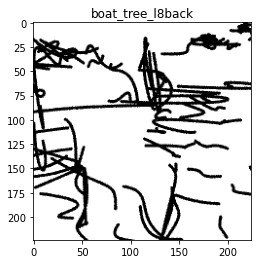

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [15]:
random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

layer = 8
# files_names = ["bull", "zebra", "panda", "chicks", "japan", "boat_tree", "venice", "van", "woman_city", "van2", "lion", "man_flowers"]
# res_names = [f"RN1_64s_{l}" for l in files_names]
# ViT_l8_64s_lion_mask
# files_names = ["woman_city", "london", "bull", "man_flowers"]
files_names = ["boat_tree"]
res_names = [f"ViT_l{layer}_64s_{l}_mask" for l in files_names]
# res_names = ["RN1_32s_mask0_complex-scene-crop", "RN1_32s_mask0_face", "RN1_32s_mask0_horse", "RN1_32s_mask0_semi-complex"]
# layers = [3,4,5,6,7,8,9,10,11]
# im_name = "semi-complex"
# im_name = "complex-scene-crop"
# files_names = [f"{im_name}-back-l{l}" for l in layers]
# res_names = [f"ViT_l{l}_64s_{im_name}_mask" for l in layers]
# files_names = ["semi-complex-back-l4", "complex-scene-back-l4"]
# res_names = ["ViT_l4_32s_semi-complex_mask", "ViT_l4_32s_complex-scene-crop_mask"]

output_pref = "/home/vinker/dev/input_images/output_sketches/"
path_res_pref = "/home/vinker/dev/background_project/experiements/big_test_07_27/"

canvas_size=224
num_strokes=64
num_cp=4
widths = torch.ones(num_strokes) * 1.5

for i in range(len(files_names)):
    output_im_name = f"{files_names[i]}_l{layer}back"#"flamingo"
    res_filename= res_names[i]#"RN1_32s_mask0_flamingo"
    # path_res = f"{path_res_pref}/{res_filename}/"


    path_res = f"{path_res_pref}/{res_filename}/"
    svg_filename = get_svg_file(path_res)
    path_svg = f"{path_res}/{svg_filename}"

    # use the mlp, start from init0
    best_svg_folder = svg_filename[:-9]
    mlp_path = f"{path_res}/{best_svg_folder}/points_mlp.pth"
    svg_init_path = f"{path_res}/{best_svg_folder}/svg_logs/svg_iter0.svg"

    points_vars = get_initial_points(svg_init_path, device=device) # list of tensors
    points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
    points_vars = points_vars / canvas_size
    points_vars = 2 * points_vars - 1

    mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
    checkpoint = torch.load(mlp_path)
    mlp.load_state_dict(checkpoint)

    with torch.no_grad():
        points_vars_ = mlp(points_vars, None)    
    img_ = render_points(points_vars_, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224).cpu().detach().numpy()
    plt.imshow(img_)
    plt.title(output_im_name)
    plt.show()
    
    imageio.imsave(f"{output_pref}/{output_im_name}.png", img_)

# imageio.imsave(f"{output_pref}/{output_im_name}.png", img_)
#     target_ = f"images/house_layer{layer}.png"
#     target, mask = get_target(target_, device, image_scale=224)
    
#     clip_conv_layer_weights=[0,0,0,0,0,0,0,0,0,0,0,0]
#     clip_conv_layer_weights[4] = 1
#     loss_clip = CLIPmaskLoss(clip_conv_layer_weights, mask)
    
    
    
    

In [18]:
import torch
import torch.nn as nn
import math

if __name__ == "__main__":
    batch_size = 128
    temperature = 5.0
    theta = torch.FloatTensor([1.753356814384460449,1.898535370826721191,0.6992630958557128906,
                                0.2227068245410919189,0.6384450793266296387,1.431323885917663574,
                                -0.05012089386582374573, -0.06672633439302444458])
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    t_gpu = theta.repeat(batch_size, 1).to(device)
    max_num = 1000000
    nan_num = 0
    for i in range(max_num):
        weight = nn.functional.gumbel_softmax(t_gpu, temperature)
        if math.isnan(torch.sum(weight)):
            nan_num+=1
    print("GPU: nan {:.3f}% probability happen, tot {}".format(100.0 * nan_num / max_num, nan_num))
    nan_num = 0
    t_cpu = theta.repeat(batch_size, 1)
    for i in range(max_num):
        weight = nn.functional.gumbel_softmax(t_cpu, temperature)
        if math.isnan(torch.sum(weight)):
            nan_num+=1
    print("CPU: nan {:.3f}% probability happen, tot {}".format(100.0 * nan_num / max_num, nan_num))

GPU: nan 0.000% probability happen, tot 0
CPU: nan 0.000% probability happen, tot 0
